In [31]:
!pip install medmnist

In [32]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn import metrics

import medmnist
from medmnist import INFO, Evaluator

In [33]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [53]:
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATES = [0.001, 0.01, 0.1]
MOMENTUM_VALUES = [0.9, 0.95, 0.99]
WEIGHT_DECAYS = [0.0001, 0.001, 0.01]
RANDOM_SEARCH_TRIALS = 6

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print(n_classes)

DataClass = getattr(medmnist, info['python_class'])
print(DataClass)

2
<class 'medmnist.dataset.BreastMNIST'>


In [54]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(device)

cuda


## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [55]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


# Load the original dataset
original_dataset = medmnist.dataset.BreastMNIST(split='train', transform=data_transform, download=download)


# # Calculate the sizes for training and validation sets
# total_size = len(original_dataset)
# train_size = int(0.8 * total_size)
# val_size = total_size - train_size

# Split the dataset into training and validation sets
# train_dataset, validation_dataset = data.random_split(original_dataset, [train_size, val_size])


# # load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz


In [56]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\zayaa\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\zayaa\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    M

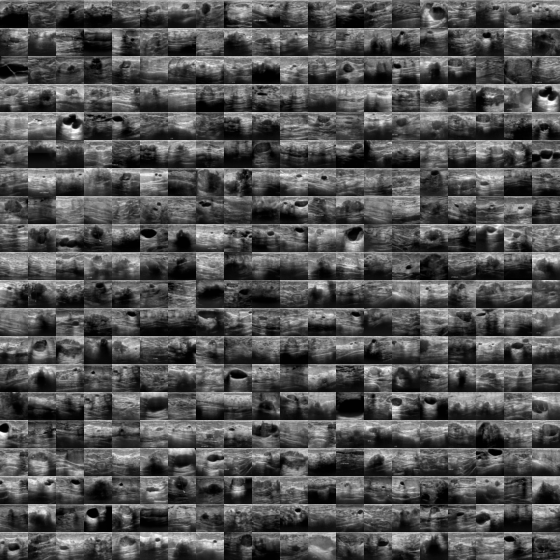

In [57]:
# montage

original_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [58]:
import torch
import torchvision.models as models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

class ExtendedNetwork(nn.Module):
    def __init__(self, original_model):
        super(ExtendedNetwork, self).__init__()
        # extracting all layers/features until the last layer to allow for edits
        every_layer_not_last = original_model.children()
        self.features = nn.Sequential(*list(every_layer_not_last))[:-1]

        self.new_layers = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.new_layers(x)
        return x

network = ExtendedNetwork(resnet18)
network.to(device=device)
# feature_list = [feature for feature in network.features.children()]
# print(feature_list)
print(network)

c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ExtendedNetwork(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [59]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

## Next, we can start to train and evaluate!

Trial 1/6
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.99, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 9/9 [00:00<00:00, 13.47it/s]


Train - Loss: 0.000187, Accuracy: 67.49% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 65.56it/s]


Validation - Loss: 0.000969, Accuracy: 31.14% 



(Train) Epoch: 1 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.68it/s]


Train - Loss: 0.000140, Accuracy: 78.81% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.49it/s]


Validation - Loss: 0.000980, Accuracy: 30.36% 



(Train) Epoch: 2 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.74it/s]


Train - Loss: 0.000141, Accuracy: 78.66% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.49it/s]


Validation - Loss: 0.001063, Accuracy: 30.36% 



(Train) Epoch: 3 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.13it/s]


Train - Loss: 0.000124, Accuracy: 82.63% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Validation - Loss: 0.000804, Accuracy: 57.48% 



(Train) Epoch: 4 on cuda: 100%|██████████| 9/9 [00:00<00:00, 20.15it/s]


Train - Loss: 0.000087, Accuracy: 87.52% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 40.00it/s]


Validation - Loss: 0.000628, Accuracy: 70.87% 



(Train) Epoch: 5 on cuda: 100%|██████████| 9/9 [00:00<00:00, 16.42it/s]


Train - Loss: 0.000142, Accuracy: 86.97% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.56it/s]


Validation - Loss: 0.000615, Accuracy: 71.32% 



(Train) Epoch: 6 on cuda: 100%|██████████| 9/9 [00:00<00:00, 20.14it/s]


Train - Loss: 0.000067, Accuracy: 91.73% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Validation - Loss: 0.000842, Accuracy: 48.44% 



(Train) Epoch: 7 on cuda: 100%|██████████| 9/9 [00:00<00:00, 17.29it/s]


Train - Loss: 0.000066, Accuracy: 91.17% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 2/2 [00:00<00:00, 20.71it/s]


Validation - Loss: 0.000657, Accuracy: 71.21% 



(Train) Epoch: 8 on cuda: 100%|██████████| 9/9 [00:00<00:00, 16.93it/s]


Train - Loss: 0.000080, Accuracy: 89.67% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 2/2 [00:00<00:00, 64.51it/s]


Validation - Loss: 0.000462, Accuracy: 88.62% 



(Train) Epoch: 9 on cuda: 100%|██████████| 9/9 [00:00<00:00, 17.96it/s]


Train - Loss: 0.000056, Accuracy: 94.14% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 2/2 [00:00<00:00, 29.62it/s]


Validation - Loss: 0.000566, Accuracy: 80.69% 



(Train) Epoch: 10 on cuda: 100%|██████████| 9/9 [00:00<00:00, 19.85it/s]


Train - Loss: 0.000084, Accuracy: 91.77% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 2/2 [00:00<00:00, 15.93it/s]


Validation - Loss: 0.000520, Accuracy: 85.04% 



(Train) Epoch: 11 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.36it/s]


Train - Loss: 0.000046, Accuracy: 93.94% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Validation - Loss: 0.000462, Accuracy: 87.39% 



(Train) Epoch: 12 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.24it/s]


Train - Loss: 0.000039, Accuracy: 94.14% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Validation - Loss: 0.000575, Accuracy: 85.04% 



(Train) Epoch: 13 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.73it/s]


Train - Loss: 0.000042, Accuracy: 93.10% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.92it/s]


Validation - Loss: 0.000705, Accuracy: 63.39% 



(Train) Epoch: 14 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.52it/s]


Train - Loss: 0.000037, Accuracy: 95.37% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Validation - Loss: 0.000544, Accuracy: 83.48% 



(Train) Epoch: 15 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.62it/s]


Train - Loss: 0.000044, Accuracy: 96.07% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.16it/s]


Validation - Loss: 0.000616, Accuracy: 73.21% 



(Train) Epoch: 16 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.55it/s]


Train - Loss: 0.000024, Accuracy: 97.05% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.92it/s]


Validation - Loss: 0.000447, Accuracy: 91.74% 



(Train) Epoch: 17 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.37it/s]


Train - Loss: 0.000026, Accuracy: 98.02% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 2/2 [00:00<00:00, 21.14it/s]


Validation - Loss: 0.000443, Accuracy: 91.74% 



(Train) Epoch: 18 on cuda: 100%|██████████| 9/9 [00:00<00:00, 18.65it/s]


Train - Loss: 0.000010, Accuracy: 99.13% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 2/2 [00:00<00:00, 46.52it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 19 on cuda: 100%|██████████| 9/9 [00:00<00:00, 16.88it/s]


Train - Loss: 0.000003, Accuracy: 100.00% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 2/2 [00:00<00:00, 43.31it/s]


Validation - Loss: 0.000437, Accuracy: 91.74% 



(Train) Epoch: 20 on cuda: 100%|██████████| 9/9 [00:00<00:00, 17.13it/s]


Train - Loss: 0.000004, Accuracy: 99.83% 



(Validation) Epoch: 20 on cuda: 100%|██████████| 2/2 [00:00<00:00, 44.29it/s]


Validation - Loss: 0.000433, Accuracy: 93.30% 



(Train) Epoch: 21 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.51it/s]


Train - Loss: 0.000009, Accuracy: 99.50% 



(Validation) Epoch: 21 on cuda: 100%|██████████| 2/2 [00:00<00:00, 64.89it/s]


Validation - Loss: 0.000432, Accuracy: 93.30% 



(Train) Epoch: 22 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 22 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.22it/s]


Validation - Loss: 0.000432, Accuracy: 93.30% 



(Train) Epoch: 23 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.72it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 23 on cuda: 100%|██████████| 2/2 [00:00<00:00, 46.55it/s]


Validation - Loss: 0.000433, Accuracy: 92.52% 



(Train) Epoch: 24 on cuda: 100%|██████████| 9/9 [00:00<00:00, 20.46it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 24 on cuda: 100%|██████████| 2/2 [00:00<00:00, 52.29it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 25 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.13it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 25 on cuda: 100%|██████████| 2/2 [00:00<00:00, 83.34it/s]


Validation - Loss: 0.000433, Accuracy: 90.96% 



(Train) Epoch: 26 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.81it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 26 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.69it/s]


Validation - Loss: 0.000434, Accuracy: 90.96% 



(Train) Epoch: 27 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.72it/s]


Train - Loss: 0.000003, Accuracy: 99.83% 



(Validation) Epoch: 27 on cuda: 100%|██████████| 2/2 [00:00<00:00, 72.19it/s]


Validation - Loss: 0.000433, Accuracy: 92.52% 



(Train) Epoch: 28 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.48it/s]


Train - Loss: 0.000001, Accuracy: 99.83% 



(Validation) Epoch: 28 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.37it/s]


Validation - Loss: 0.000434, Accuracy: 90.96% 



(Train) Epoch: 29 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.41it/s]


Train - Loss: 0.000001, Accuracy: 100.00% 



(Validation) Epoch: 29 on cuda: 100%|██████████| 2/2 [00:00<00:00, 71.15it/s]


Validation - Loss: 0.000434, Accuracy: 91.74% 

Trial 2/6
TESTING ON HYPERPARAMETERS: Learning Rate: 0.1, Momentum: 0.95, Weight Decay: 0.01



(Train) Epoch: 0 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.40it/s]


Train - Loss: 0.001578, Accuracy: 60.09% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.11it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 1 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.48it/s]


Train - Loss: 0.000522, Accuracy: 56.92% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.51it/s]


Validation - Loss: 0.001073, Accuracy: 30.36% 



(Train) Epoch: 2 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.09it/s]


Train - Loss: 0.000340, Accuracy: 60.79% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 57.59it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 3 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.64it/s]


Train - Loss: 0.000332, Accuracy: 59.49% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.20it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 4 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.30it/s]


Train - Loss: 0.000370, Accuracy: 58.47% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 72.93it/s]


Validation - Loss: 0.001017, Accuracy: 32.70% 



(Train) Epoch: 5 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.15it/s]


Train - Loss: 0.000268, Accuracy: 65.06% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.62it/s]


Validation - Loss: 0.000723, Accuracy: 69.64% 



(Train) Epoch: 6 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.35it/s]


Train - Loss: 0.000180, Accuracy: 71.38% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.30it/s]


Validation - Loss: 0.000722, Accuracy: 69.64% 



(Train) Epoch: 7 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.96it/s]


Train - Loss: 0.000163, Accuracy: 71.50% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.25it/s]


Validation - Loss: 0.000717, Accuracy: 69.64% 



(Train) Epoch: 8 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.75it/s]


Train - Loss: 0.000164, Accuracy: 72.64% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 2/2 [00:00<00:00, 82.77it/s]


Validation - Loss: 0.000715, Accuracy: 69.64% 



(Train) Epoch: 9 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.41it/s]


Train - Loss: 0.000157, Accuracy: 73.48% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 2/2 [00:00<00:00, 41.41it/s]


Validation - Loss: 0.000710, Accuracy: 69.64% 



(Train) Epoch: 10 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s]


Train - Loss: 0.000154, Accuracy: 73.34% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 2/2 [00:00<00:00, 59.05it/s]


Validation - Loss: 0.000713, Accuracy: 69.64% 



(Train) Epoch: 11 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.85it/s]


Train - Loss: 0.000159, Accuracy: 72.97% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 2/2 [00:00<00:00, 64.25it/s]


Validation - Loss: 0.000709, Accuracy: 69.64% 



(Train) Epoch: 12 on cuda: 100%|██████████| 9/9 [00:00<00:00, 21.65it/s]


Train - Loss: 0.000150, Accuracy: 75.26% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Validation - Loss: 0.000698, Accuracy: 69.64% 



(Train) Epoch: 13 on cuda: 100%|██████████| 9/9 [00:00<00:00, 20.80it/s]


Train - Loss: 0.000147, Accuracy: 76.05% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 2/2 [00:00<00:00, 56.88it/s]


Validation - Loss: 0.000699, Accuracy: 69.64% 



(Train) Epoch: 14 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.52it/s]


Train - Loss: 0.000141, Accuracy: 77.35% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s]


Validation - Loss: 0.000608, Accuracy: 74.00% 



(Train) Epoch: 15 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.02it/s]


Train - Loss: 0.000127, Accuracy: 81.16% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 2/2 [00:00<00:00, 61.40it/s]


Validation - Loss: 0.000599, Accuracy: 78.79% 



(Train) Epoch: 16 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.60it/s]


Train - Loss: 0.000127, Accuracy: 79.79% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.15it/s]


Validation - Loss: 0.000690, Accuracy: 65.40% 



(Train) Epoch: 17 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.07it/s]


Train - Loss: 0.000124, Accuracy: 82.61% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 2/2 [00:00<00:00, 37.85it/s]


Validation - Loss: 0.000563, Accuracy: 80.69% 



(Train) Epoch: 18 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s]


Train - Loss: 0.000136, Accuracy: 80.72% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.32it/s]


Validation - Loss: 0.000714, Accuracy: 69.64% 



(Train) Epoch: 19 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s]


Train - Loss: 0.000120, Accuracy: 82.28% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 2/2 [00:00<00:00, 59.27it/s]


Validation - Loss: 0.000582, Accuracy: 77.57% 



(Train) Epoch: 20 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.71it/s]


Train - Loss: 0.000113, Accuracy: 82.09% 



(Validation) Epoch: 20 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.49it/s]


Validation - Loss: 0.000548, Accuracy: 90.96% 



(Train) Epoch: 21 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.98it/s]


Train - Loss: 0.000105, Accuracy: 83.74% 



(Validation) Epoch: 21 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.96it/s]


Validation - Loss: 0.000705, Accuracy: 69.64% 



(Train) Epoch: 22 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.35it/s]


Train - Loss: 0.000096, Accuracy: 86.65% 



(Validation) Epoch: 22 on cuda: 100%|██████████| 2/2 [00:00<00:00, 72.86it/s]


Validation - Loss: 0.000662, Accuracy: 66.52% 



(Train) Epoch: 23 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.66it/s]


Train - Loss: 0.000109, Accuracy: 83.61% 



(Validation) Epoch: 23 on cuda: 100%|██████████| 2/2 [00:00<00:00, 56.85it/s]


Validation - Loss: 0.000722, Accuracy: 69.64% 



(Train) Epoch: 24 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.75it/s]


Train - Loss: 0.000096, Accuracy: 84.78% 



(Validation) Epoch: 24 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.78it/s]


Validation - Loss: 0.000591, Accuracy: 74.00% 



(Train) Epoch: 25 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.98it/s]


Train - Loss: 0.000091, Accuracy: 88.62% 



(Validation) Epoch: 25 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.85it/s]


Validation - Loss: 0.000475, Accuracy: 88.62% 



(Train) Epoch: 26 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.27it/s]


Train - Loss: 0.000079, Accuracy: 91.57% 



(Validation) Epoch: 26 on cuda: 100%|██████████| 2/2 [00:00<00:00, 78.22it/s]


Validation - Loss: 0.000445, Accuracy: 92.97% 



(Train) Epoch: 27 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.72it/s]


Train - Loss: 0.000068, Accuracy: 90.73% 



(Validation) Epoch: 27 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.71it/s]


Validation - Loss: 0.000460, Accuracy: 92.97% 



(Train) Epoch: 28 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.44it/s]


Train - Loss: 0.000065, Accuracy: 90.90% 



(Validation) Epoch: 28 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.34it/s]


Validation - Loss: 0.000435, Accuracy: 94.53% 



(Train) Epoch: 29 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.11it/s]


Train - Loss: 0.000047, Accuracy: 94.99% 



(Validation) Epoch: 29 on cuda: 100%|██████████| 2/2 [00:00<00:00, 71.56it/s]


Validation - Loss: 0.000485, Accuracy: 88.62% 

Trial 3/6
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.95, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 9/9 [00:00<00:00, 20.64it/s]


Train - Loss: 0.000049, Accuracy: 93.44% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 65.01it/s]


Validation - Loss: 0.000407, Accuracy: 93.75% 



(Train) Epoch: 1 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.00it/s]


Train - Loss: 0.000050, Accuracy: 92.77% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 72.62it/s]


Validation - Loss: 0.000447, Accuracy: 90.18% 



(Train) Epoch: 2 on cuda: 100%|██████████| 9/9 [00:00<00:00, 21.91it/s]


Train - Loss: 0.000038, Accuracy: 95.89% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 67.19it/s]


Validation - Loss: 0.000384, Accuracy: 94.53% 



(Train) Epoch: 3 on cuda: 100%|██████████| 9/9 [00:00<00:00, 18.95it/s]


Train - Loss: 0.000031, Accuracy: 95.49% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 71.49it/s]


Validation - Loss: 0.000438, Accuracy: 90.96% 



(Train) Epoch: 4 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.23it/s]


Train - Loss: 0.000026, Accuracy: 96.57% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.83it/s]


Validation - Loss: 0.000432, Accuracy: 90.96% 



(Train) Epoch: 5 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.15it/s]


Train - Loss: 0.000014, Accuracy: 98.28% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 2/2 [00:00<00:00, 67.56it/s]


Validation - Loss: 0.000422, Accuracy: 91.74% 



(Train) Epoch: 6 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.07it/s]


Train - Loss: 0.000024, Accuracy: 97.78% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.39it/s]


Validation - Loss: 0.000432, Accuracy: 91.74% 



(Train) Epoch: 7 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.49it/s]


Train - Loss: 0.000008, Accuracy: 99.31% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.83it/s]


Validation - Loss: 0.000431, Accuracy: 91.74% 



(Train) Epoch: 8 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.38it/s]


Train - Loss: 0.000044, Accuracy: 97.34% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 2/2 [00:00<00:00, 69.49it/s]


Validation - Loss: 0.000431, Accuracy: 92.52% 



(Train) Epoch: 9 on cuda: 100%|██████████| 9/9 [00:00<00:00, 19.70it/s]


Train - Loss: 0.000005, Accuracy: 99.48% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 2/2 [00:00<00:00, 57.94it/s]


Validation - Loss: 0.000431, Accuracy: 92.52% 



(Train) Epoch: 10 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.90it/s]


Train - Loss: 0.000013, Accuracy: 98.96% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.01it/s]


Validation - Loss: 0.000432, Accuracy: 91.74% 



(Train) Epoch: 11 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.80it/s]


Train - Loss: 0.000003, Accuracy: 99.65% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.25it/s]


Validation - Loss: 0.000432, Accuracy: 92.52% 



(Train) Epoch: 12 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.42it/s]


Train - Loss: 0.000005, Accuracy: 99.83% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 2/2 [00:00<00:00, 81.09it/s]


Validation - Loss: 0.000433, Accuracy: 92.52% 



(Train) Epoch: 13 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.22it/s]


Train - Loss: 0.000003, Accuracy: 100.00% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.92it/s]


Validation - Loss: 0.000432, Accuracy: 92.52% 



(Train) Epoch: 14 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.55it/s]


Train - Loss: 0.000004, Accuracy: 99.65% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 2/2 [00:00<00:00, 71.42it/s]


Validation - Loss: 0.000432, Accuracy: 92.52% 



(Train) Epoch: 15 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.56it/s]


Train - Loss: 0.000005, Accuracy: 99.65% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 2/2 [00:00<00:00, 31.87it/s]


Validation - Loss: 0.000432, Accuracy: 92.52% 



(Train) Epoch: 16 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.30it/s]


Train - Loss: 0.000004, Accuracy: 99.65% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 2/2 [00:00<00:00, 78.04it/s]


Validation - Loss: 0.000432, Accuracy: 92.52% 



(Train) Epoch: 17 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.17it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 2/2 [00:00<00:00, 75.82it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 18 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.93it/s]


Train - Loss: 0.000004, Accuracy: 99.31% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 2/2 [00:00<00:00, 82.36it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 19 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.60it/s]


Train - Loss: 0.000004, Accuracy: 99.48% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.82it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 20 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.57it/s]


Train - Loss: 0.000003, Accuracy: 99.65% 



(Validation) Epoch: 20 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.95it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 21 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.46it/s]


Train - Loss: 0.000004, Accuracy: 99.48% 



(Validation) Epoch: 21 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.00it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 22 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.05it/s]


Train - Loss: 0.000006, Accuracy: 99.31% 



(Validation) Epoch: 22 on cuda: 100%|██████████| 2/2 [00:00<00:00, 64.49it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 23 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.53it/s]


Train - Loss: 0.000002, Accuracy: 100.00% 



(Validation) Epoch: 23 on cuda: 100%|██████████| 2/2 [00:00<00:00, 81.29it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 24 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.50it/s]


Train - Loss: 0.000006, Accuracy: 99.33% 



(Validation) Epoch: 24 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.54it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 25 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.20it/s]


Train - Loss: 0.000003, Accuracy: 99.83% 



(Validation) Epoch: 25 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.52it/s]


Validation - Loss: 0.000434, Accuracy: 91.74% 



(Train) Epoch: 26 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.19it/s]


Train - Loss: 0.000003, Accuracy: 100.00% 



(Validation) Epoch: 26 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.72it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 27 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.11it/s]


Train - Loss: 0.000011, Accuracy: 99.33% 



(Validation) Epoch: 27 on cuda: 100%|██████████| 2/2 [00:00<00:00, 63.72it/s]


Validation - Loss: 0.000433, Accuracy: 92.52% 



(Train) Epoch: 28 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.57it/s]


Train - Loss: 0.000005, Accuracy: 99.65% 



(Validation) Epoch: 28 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.15it/s]


Validation - Loss: 0.000433, Accuracy: 91.74% 



(Train) Epoch: 29 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.78it/s]


Train - Loss: 0.000056, Accuracy: 97.69% 



(Validation) Epoch: 29 on cuda: 100%|██████████| 2/2 [00:00<00:00, 37.24it/s]


Validation - Loss: 0.000434, Accuracy: 91.74% 

Trial 4/6
TESTING ON HYPERPARAMETERS: Learning Rate: 0.01, Momentum: 0.95, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.06it/s]


Train - Loss: 0.000192, Accuracy: 80.35% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.29it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 1 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.03it/s]


Train - Loss: 0.000104, Accuracy: 85.02% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.74it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 2 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.73it/s]


Train - Loss: 0.000093, Accuracy: 86.83% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.52it/s]


Validation - Loss: 0.001057, Accuracy: 34.26% 



(Train) Epoch: 3 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.20it/s]


Train - Loss: 0.000093, Accuracy: 89.55% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 66.77it/s]


Validation - Loss: 0.000458, Accuracy: 87.05% 



(Train) Epoch: 4 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s]


Train - Loss: 0.000069, Accuracy: 88.24% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.20it/s]


Validation - Loss: 0.000496, Accuracy: 87.83% 



(Train) Epoch: 5 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.77it/s]


Train - Loss: 0.000062, Accuracy: 90.88% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.62it/s]


Validation - Loss: 0.000436, Accuracy: 90.18% 



(Train) Epoch: 6 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.10it/s]


Train - Loss: 0.000052, Accuracy: 92.23% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 2/2 [00:00<00:00, 34.56it/s]


Validation - Loss: 0.000608, Accuracy: 74.44% 



(Train) Epoch: 7 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.22it/s]


Train - Loss: 0.000088, Accuracy: 90.53% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 2/2 [00:00<00:00, 53.14it/s]


Validation - Loss: 0.000677, Accuracy: 70.42% 



(Train) Epoch: 8 on cuda: 100%|██████████| 9/9 [00:00<00:00, 17.58it/s]


Train - Loss: 0.000084, Accuracy: 90.05% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.12it/s]


Validation - Loss: 0.000666, Accuracy: 70.09% 



(Train) Epoch: 9 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.29it/s]


Train - Loss: 0.000097, Accuracy: 89.75% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.63it/s]


Validation - Loss: 0.000630, Accuracy: 75.56% 



(Train) Epoch: 10 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.81it/s]


Train - Loss: 0.000058, Accuracy: 92.94% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 2/2 [00:00<00:00, 71.88it/s]


Validation - Loss: 0.000438, Accuracy: 92.19% 



(Train) Epoch: 11 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.97it/s]


Train - Loss: 0.000045, Accuracy: 95.16% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 2/2 [00:00<00:00, 69.16it/s]


Validation - Loss: 0.000439, Accuracy: 89.40% 



(Train) Epoch: 12 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.85it/s]


Train - Loss: 0.000042, Accuracy: 94.64% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 2/2 [00:00<00:00, 61.87it/s]


Validation - Loss: 0.000422, Accuracy: 88.62% 



(Train) Epoch: 13 on cuda: 100%|██████████| 9/9 [00:00<00:00, 19.77it/s]


Train - Loss: 0.000038, Accuracy: 95.53% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.28it/s]


Validation - Loss: 0.000411, Accuracy: 92.19% 



(Train) Epoch: 14 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s]


Train - Loss: 0.000027, Accuracy: 97.44% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.56it/s]


Validation - Loss: 0.000426, Accuracy: 88.62% 



(Train) Epoch: 15 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.94it/s]


Train - Loss: 0.000020, Accuracy: 97.78% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 2/2 [00:00<00:00, 59.33it/s]


Validation - Loss: 0.000413, Accuracy: 89.40% 



(Train) Epoch: 16 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.30it/s]


Train - Loss: 0.000019, Accuracy: 98.09% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 2/2 [00:00<00:00, 75.56it/s]


Validation - Loss: 0.000440, Accuracy: 90.18% 



(Train) Epoch: 17 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.77it/s]


Train - Loss: 0.000015, Accuracy: 98.81% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 2/2 [00:00<00:00, 85.67it/s]


Validation - Loss: 0.000435, Accuracy: 89.40% 



(Train) Epoch: 18 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.13it/s]


Train - Loss: 0.000013, Accuracy: 99.13% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.60it/s]


Validation - Loss: 0.000437, Accuracy: 90.96% 



(Train) Epoch: 19 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.01it/s]


Train - Loss: 0.000015, Accuracy: 98.83% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 2/2 [00:00<00:00, 36.21it/s]


Validation - Loss: 0.000438, Accuracy: 90.96% 



(Train) Epoch: 20 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.73it/s]


Train - Loss: 0.000016, Accuracy: 98.78% 



(Validation) Epoch: 20 on cuda: 100%|██████████| 2/2 [00:00<00:00, 68.80it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 21 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.38it/s]


Train - Loss: 0.000017, Accuracy: 98.83% 



(Validation) Epoch: 21 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.47it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 22 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.99it/s]


Train - Loss: 0.000009, Accuracy: 99.31% 



(Validation) Epoch: 22 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.71it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 23 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.63it/s]


Train - Loss: 0.000012, Accuracy: 98.96% 



(Validation) Epoch: 23 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.69it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 24 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.17it/s]


Train - Loss: 0.000012, Accuracy: 98.61% 



(Validation) Epoch: 24 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.85it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 25 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.82it/s]


Train - Loss: 0.000008, Accuracy: 99.65% 



(Validation) Epoch: 25 on cuda: 100%|██████████| 2/2 [00:00<00:00, 23.40it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 26 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.52it/s]


Train - Loss: 0.000014, Accuracy: 98.96% 



(Validation) Epoch: 26 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.40it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 27 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.37it/s]


Train - Loss: 0.000012, Accuracy: 98.98% 



(Validation) Epoch: 27 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.19it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 28 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.54it/s]


Train - Loss: 0.000012, Accuracy: 99.13% 



(Validation) Epoch: 28 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.35it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 



(Train) Epoch: 29 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.06it/s]


Train - Loss: 0.000010, Accuracy: 99.48% 



(Validation) Epoch: 29 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.43it/s]


Validation - Loss: 0.000439, Accuracy: 90.96% 

Trial 5/6
TESTING ON HYPERPARAMETERS: Learning Rate: 0.1, Momentum: 0.99, Weight Decay: 0.01



(Train) Epoch: 0 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.87it/s]


Train - Loss: 0.000941, Accuracy: 63.23% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.48it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 1 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.73it/s]


Train - Loss: 0.000583, Accuracy: 57.15% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.24it/s]


Validation - Loss: 0.000724, Accuracy: 69.64% 



(Train) Epoch: 2 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.10it/s]


Train - Loss: 0.000378, Accuracy: 59.92% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 81.24it/s]


Validation - Loss: 0.000726, Accuracy: 69.64% 



(Train) Epoch: 3 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s]


Train - Loss: 0.000323, Accuracy: 60.99% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.97it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 4 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.98it/s]


Train - Loss: 0.000300, Accuracy: 59.47% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.40it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 5 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.91it/s]


Train - Loss: 0.000342, Accuracy: 60.61% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.97it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 6 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.38it/s]


Train - Loss: 0.000290, Accuracy: 65.00% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.73it/s]


Validation - Loss: 0.000727, Accuracy: 69.64% 



(Train) Epoch: 7 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.22it/s]


Train - Loss: 0.000166, Accuracy: 71.04% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.61it/s]


Validation - Loss: 0.000718, Accuracy: 69.64% 



(Train) Epoch: 8 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.08it/s]


Train - Loss: 0.000164, Accuracy: 71.79% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.63it/s]


Validation - Loss: 0.000720, Accuracy: 69.64% 



(Train) Epoch: 9 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.48it/s]


Train - Loss: 0.000148, Accuracy: 73.41% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 2/2 [00:00<00:00, 75.32it/s]


Validation - Loss: 0.000718, Accuracy: 69.64% 



(Train) Epoch: 10 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.84it/s]


Train - Loss: 0.000180, Accuracy: 73.15% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.25it/s]


Validation - Loss: 0.000717, Accuracy: 69.64% 



(Train) Epoch: 11 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.68it/s]


Train - Loss: 0.000150, Accuracy: 73.67% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.92it/s]


Validation - Loss: 0.000721, Accuracy: 69.64% 



(Train) Epoch: 12 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.47it/s]


Train - Loss: 0.000156, Accuracy: 72.93% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 2/2 [00:00<00:00, 72.47it/s]


Validation - Loss: 0.000699, Accuracy: 69.64% 



(Train) Epoch: 13 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.62it/s]


Train - Loss: 0.000149, Accuracy: 75.68% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]


Validation - Loss: 0.000704, Accuracy: 69.64% 



(Train) Epoch: 14 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.04it/s]


Train - Loss: 0.000149, Accuracy: 76.66% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.01it/s]


Validation - Loss: 0.000682, Accuracy: 69.64% 



(Train) Epoch: 15 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.99it/s]


Train - Loss: 0.000149, Accuracy: 75.01% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 2/2 [00:00<00:00, 65.74it/s]


Validation - Loss: 0.000603, Accuracy: 85.83% 



(Train) Epoch: 16 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.98it/s]


Train - Loss: 0.000148, Accuracy: 77.92% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.61it/s]


Validation - Loss: 0.000632, Accuracy: 73.66% 



(Train) Epoch: 17 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.11it/s]


Train - Loss: 0.000134, Accuracy: 79.83% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 2/2 [00:00<00:00, 83.12it/s]


Validation - Loss: 0.000722, Accuracy: 69.64% 



(Train) Epoch: 18 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.39it/s]


Train - Loss: 0.000121, Accuracy: 80.85% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.06it/s]


Validation - Loss: 0.000606, Accuracy: 78.35% 



(Train) Epoch: 19 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.03it/s]


Train - Loss: 0.000117, Accuracy: 84.50% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 2/2 [00:00<00:00, 72.20it/s]


Validation - Loss: 0.000499, Accuracy: 93.75% 



(Train) Epoch: 20 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.26it/s]


Train - Loss: 0.000121, Accuracy: 84.75% 



(Validation) Epoch: 20 on cuda: 100%|██████████| 2/2 [00:00<00:00, 78.03it/s]


Validation - Loss: 0.000646, Accuracy: 74.00% 



(Train) Epoch: 21 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.31it/s]


Train - Loss: 0.000115, Accuracy: 83.57% 



(Validation) Epoch: 21 on cuda: 100%|██████████| 2/2 [00:00<00:00, 75.17it/s]


Validation - Loss: 0.000598, Accuracy: 77.57% 



(Train) Epoch: 22 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.95it/s]


Train - Loss: 0.000112, Accuracy: 85.71% 



(Validation) Epoch: 22 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.32it/s]


Validation - Loss: 0.000703, Accuracy: 70.42% 



(Train) Epoch: 23 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.31it/s]


Train - Loss: 0.000112, Accuracy: 85.17% 



(Validation) Epoch: 23 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.35it/s]


Validation - Loss: 0.000518, Accuracy: 85.04% 



(Train) Epoch: 24 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.48it/s]


Train - Loss: 0.000090, Accuracy: 89.30% 



(Validation) Epoch: 24 on cuda: 100%|██████████| 2/2 [00:00<00:00, 78.32it/s]


Validation - Loss: 0.000507, Accuracy: 85.04% 



(Train) Epoch: 25 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.11it/s]


Train - Loss: 0.000081, Accuracy: 90.67% 



(Validation) Epoch: 25 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.28it/s]


Validation - Loss: 0.000468, Accuracy: 89.40% 



(Train) Epoch: 26 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.27it/s]


Train - Loss: 0.000073, Accuracy: 91.73% 



(Validation) Epoch: 26 on cuda: 100%|██████████| 2/2 [00:00<00:00, 73.74it/s]


Validation - Loss: 0.000483, Accuracy: 90.18% 



(Train) Epoch: 27 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.79it/s]


Train - Loss: 0.000068, Accuracy: 91.71% 



(Validation) Epoch: 27 on cuda: 100%|██████████| 2/2 [00:00<00:00, 67.70it/s]


Validation - Loss: 0.000456, Accuracy: 89.40% 



(Train) Epoch: 28 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.66it/s]


Train - Loss: 0.000061, Accuracy: 92.92% 



(Validation) Epoch: 28 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.16it/s]


Validation - Loss: 0.000472, Accuracy: 89.40% 



(Train) Epoch: 29 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.13it/s]


Train - Loss: 0.000054, Accuracy: 94.31% 



(Validation) Epoch: 29 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.74it/s]


Validation - Loss: 0.000463, Accuracy: 91.74% 

Trial 6/6
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.95, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.20it/s]


Train - Loss: 0.000051, Accuracy: 94.10% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.46it/s]


Validation - Loss: 0.000458, Accuracy: 89.40% 



(Train) Epoch: 1 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.25it/s]


Train - Loss: 0.000044, Accuracy: 94.97% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 2/2 [00:00<00:00, 24.97it/s]


Validation - Loss: 0.000463, Accuracy: 90.18% 



(Train) Epoch: 2 on cuda: 100%|██████████| 9/9 [00:00<00:00, 20.56it/s]


Train - Loss: 0.000040, Accuracy: 96.05% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 2/2 [00:00<00:00, 62.30it/s]


Validation - Loss: 0.000450, Accuracy: 91.74% 



(Train) Epoch: 3 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.09it/s]


Train - Loss: 0.000033, Accuracy: 96.18% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.37it/s]


Validation - Loss: 0.000480, Accuracy: 87.39% 



(Train) Epoch: 4 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.39it/s]


Train - Loss: 0.000024, Accuracy: 97.22% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 2/2 [00:00<00:00, 72.13it/s]


Validation - Loss: 0.000447, Accuracy: 90.96% 



(Train) Epoch: 5 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.26it/s]


Train - Loss: 0.000031, Accuracy: 96.40% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.70it/s]


Validation - Loss: 0.000465, Accuracy: 88.17% 



(Train) Epoch: 6 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.90it/s]


Train - Loss: 0.000025, Accuracy: 98.28% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 2/2 [00:00<00:00, 77.47it/s]


Validation - Loss: 0.000442, Accuracy: 90.96% 



(Train) Epoch: 7 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.09it/s]


Train - Loss: 0.000018, Accuracy: 97.74% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 2/2 [00:00<00:00, 67.73it/s]


Validation - Loss: 0.000441, Accuracy: 90.96% 



(Train) Epoch: 8 on cuda: 100%|██████████| 9/9 [00:00<00:00, 20.66it/s]


Train - Loss: 0.000007, Accuracy: 99.31% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 2/2 [00:00<00:00, 56.13it/s]


Validation - Loss: 0.000503, Accuracy: 86.61% 



(Train) Epoch: 9 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.36it/s]


Train - Loss: 0.000007, Accuracy: 98.96% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 2/2 [00:00<00:00, 66.65it/s]


Validation - Loss: 0.000441, Accuracy: 90.18% 



(Train) Epoch: 10 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.28it/s]


Train - Loss: 0.000018, Accuracy: 98.65% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.51it/s]


Validation - Loss: 0.000474, Accuracy: 88.17% 



(Train) Epoch: 11 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.82it/s]


Train - Loss: 0.000008, Accuracy: 99.13% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 2/2 [00:00<00:00, 79.04it/s]


Validation - Loss: 0.000495, Accuracy: 88.95% 



(Train) Epoch: 12 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.76it/s]


Train - Loss: 0.000008, Accuracy: 99.31% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 2/2 [00:00<00:00, 67.81it/s]


Validation - Loss: 0.000488, Accuracy: 89.73% 



(Train) Epoch: 13 on cuda: 100%|██████████| 9/9 [00:00<00:00, 26.05it/s]


Train - Loss: 0.000005, Accuracy: 99.31% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 2/2 [00:00<00:00, 76.93it/s]


Validation - Loss: 0.000486, Accuracy: 89.73% 



(Train) Epoch: 14 on cuda: 100%|██████████| 9/9 [00:00<00:00, 21.00it/s]


Train - Loss: 0.000002, Accuracy: 100.00% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 2/2 [00:00<00:00, 64.86it/s]


Validation - Loss: 0.000482, Accuracy: 89.73% 



(Train) Epoch: 15 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.46it/s]


Train - Loss: 0.000007, Accuracy: 99.50% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 2/2 [00:00<00:00, 71.43it/s]


Validation - Loss: 0.000484, Accuracy: 89.73% 



(Train) Epoch: 16 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.84it/s]


Train - Loss: 0.000005, Accuracy: 99.48% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 2/2 [00:00<00:00, 68.88it/s]


Validation - Loss: 0.000481, Accuracy: 88.95% 



(Train) Epoch: 17 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.00it/s]


Train - Loss: 0.000002, Accuracy: 100.00% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Validation - Loss: 0.000476, Accuracy: 88.17% 



(Train) Epoch: 18 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.19it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 2/2 [00:00<00:00, 58.83it/s]


Validation - Loss: 0.000483, Accuracy: 88.95% 



(Train) Epoch: 19 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.07it/s]


Train - Loss: 0.000002, Accuracy: 100.00% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 2/2 [00:00<00:00, 74.07it/s]


Validation - Loss: 0.000487, Accuracy: 88.95% 



(Train) Epoch: 20 on cuda: 100%|██████████| 9/9 [00:00<00:00, 25.49it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 20 on cuda: 100%|██████████| 2/2 [00:00<00:00, 35.09it/s]


Validation - Loss: 0.000485, Accuracy: 88.95% 



(Train) Epoch: 21 on cuda: 100%|██████████| 9/9 [00:00<00:00, 22.44it/s]


Train - Loss: 0.000021, Accuracy: 98.85% 



(Validation) Epoch: 21 on cuda: 100%|██████████| 2/2 [00:00<00:00, 70.00it/s]


Validation - Loss: 0.000486, Accuracy: 89.73% 



(Train) Epoch: 22 on cuda: 100%|██████████| 9/9 [00:00<00:00, 19.35it/s]


Train - Loss: 0.000005, Accuracy: 99.65% 



(Validation) Epoch: 22 on cuda: 100%|██████████| 2/2 [00:00<00:00, 53.23it/s]


Validation - Loss: 0.000490, Accuracy: 88.95% 



(Train) Epoch: 23 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.55it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 23 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s]


Validation - Loss: 0.000489, Accuracy: 89.73% 



(Train) Epoch: 24 on cuda: 100%|██████████| 9/9 [00:00<00:00, 24.12it/s]


Train - Loss: 0.000003, Accuracy: 99.83% 



(Validation) Epoch: 24 on cuda: 100%|██████████| 2/2 [00:00<00:00, 60.61it/s]


Validation - Loss: 0.000490, Accuracy: 89.73% 



(Train) Epoch: 25 on cuda: 100%|██████████| 9/9 [00:00<00:00, 19.82it/s]


Train - Loss: 0.000002, Accuracy: 100.00% 



(Validation) Epoch: 25 on cuda: 100%|██████████| 2/2 [00:00<00:00, 48.78it/s]


Validation - Loss: 0.000490, Accuracy: 89.73% 



(Train) Epoch: 26 on cuda: 100%|██████████| 9/9 [00:00<00:00, 18.70it/s]


Train - Loss: 0.000003, Accuracy: 99.48% 



(Validation) Epoch: 26 on cuda: 100%|██████████| 2/2 [00:00<00:00, 58.83it/s]


Validation - Loss: 0.000489, Accuracy: 88.95% 



(Train) Epoch: 27 on cuda: 100%|██████████| 9/9 [00:00<00:00, 16.63it/s]


Train - Loss: 0.000002, Accuracy: 99.83% 



(Validation) Epoch: 27 on cuda: 100%|██████████| 2/2 [00:00<00:00, 55.56it/s]


Validation - Loss: 0.000486, Accuracy: 88.95% 



(Train) Epoch: 28 on cuda: 100%|██████████| 9/9 [00:00<00:00, 19.47it/s]


Train - Loss: 0.000002, Accuracy: 100.00% 



(Validation) Epoch: 28 on cuda: 100%|██████████| 2/2 [00:00<00:00, 57.14it/s]


Validation - Loss: 0.000489, Accuracy: 88.95% 



(Train) Epoch: 29 on cuda: 100%|██████████| 9/9 [00:00<00:00, 23.28it/s]


Train - Loss: 0.000010, Accuracy: 99.13% 



(Validation) Epoch: 29 on cuda: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s]


Validation - Loss: 0.000486, Accuracy: 88.95% 


Best Hyperparameters:
{'learning_rate': 0.001, 'momentum': 0.99, 'weight_decay': 0.001}
Best Training Accuracy: 100.00%
Best Validation Accuracy: 94.53%


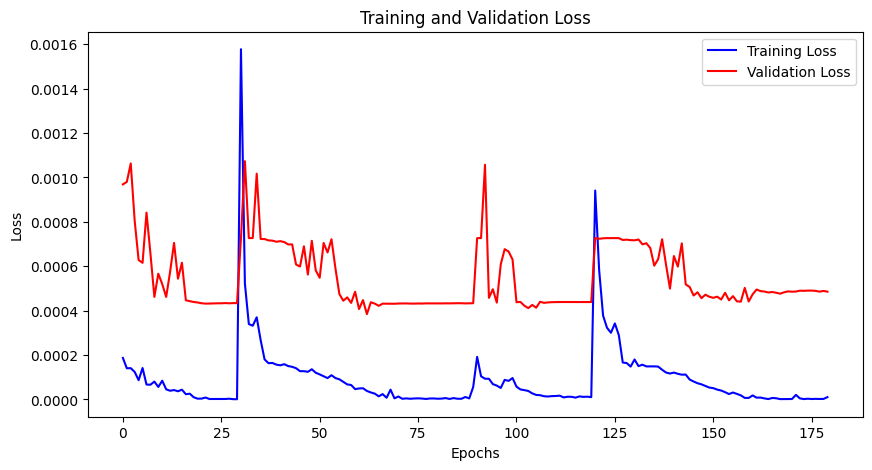

In [60]:
import matplotlib.pyplot as plt

# train

#loss_function = nn.BCEWithLogitsLoss() # Each sample belongs to one of two classes (0 or 1) so we can use this loss function.
loss_function = nn.CrossEntropyLoss()

best_train_accuracy = 0
best_val_accuracy = 0
best_hyperparameters = {}

# Lists to store average losses
avg_train_losses = []
avg_val_losses = []


for trial in range(RANDOM_SEARCH_TRIALS):
    print(f"Trial {trial + 1}/{RANDOM_SEARCH_TRIALS}")

    learning_rate = np.random.choice(LEARNING_RATES)
    momentum = np.random.choice(MOMENTUM_VALUES)
    weight_decay = np.random.choice(WEIGHT_DECAYS)

    print(f"TESTING ON HYPERPARAMETERS: Learning Rate: {learning_rate}, Momentum: {momentum}, Weight Decay: {weight_decay}\n")

    optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    for epoch in range(NUM_EPOCHS):
        train_correct = 0
        train_total = 0
        test_correct = 0
        test_total = 0
        # running loss and acurracy
        running_loss = 0.0
        running_accuracy = 0.0

        network.train()
        for inputs, targets in tqdm(train_loader, desc="(Train) Epoch: " + str(epoch) + " on " + str(device)):
            # forward + backward + optimize
            inputs, targets = inputs.to(device), targets.to(device)
            
            #targets = targets.squeeze(1).long()

            optimizer.zero_grad()
            outputs = network(inputs)

            targets = targets.squeeze().long()
            # targets_one_hot = torch.nn.functional.one_hot(targets.long(), num_classes=2).float()
            # targets_one_hot = targets_one_hot.squeeze(1)
            
            # Call Loss function
            cross_entropy_loss = loss_function(outputs, targets)

            # Call Backward function
            cross_entropy_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += cross_entropy_loss.item() / len(inputs)
            running_accuracy += accuracy(outputs, targets)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        avg_train_losses.append(epoch_loss)

        print("Train - Loss: {:.6f}, Accuracy: {:.2f}%".format(epoch_loss, running_accuracy / len(train_loader) * 100), "\n")

        # Validation
        network.eval()
        val_running_loss = 0.0
        val_running_accuracy = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in tqdm(validation_loader, desc="(Validation) Epoch: " + str(epoch) + " on " + str(device)):
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                val_outputs = network(val_inputs)

                val_outputs = F.softmax(val_outputs, dim=1)

                val_targets = val_targets.squeeze().long()
                # val_targets_one_hot = torch.nn.functional.one_hot(val_targets.long(), num_classes=2).float()
                # val_targets_one_hot = val_targets_one_hot.squeeze(1)

                val_loss = loss_function(val_outputs, val_targets)

                val_running_loss += val_loss.item() / len(val_inputs)
                val_running_accuracy += accuracy(val_outputs, val_targets)

        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        avg_val_losses.append(val_epoch_loss)

        scheduler.step(val_epoch_loss)

        print("Validation - Loss: {:.6f}, Accuracy: {:.2f}%".format(val_epoch_loss, val_running_accuracy / len(validation_loader) * 100), "\n")

        # Check if this trial has the best accuracy
        if running_accuracy > best_train_accuracy:
            best_train_accuracy = running_accuracy
            best_hyperparameters = {
                "learning_rate": learning_rate,
                "momentum": momentum,
                "weight_decay": weight_decay
            }
        if val_running_accuracy > best_val_accuracy:
            best_val_accuracy = val_running_accuracy

# Print the best hyperparameters and accuracy
print("\nBest Hyperparameters:")
print(best_hyperparameters)
print("Best Training Accuracy: {:.2f}%".format(best_train_accuracy / len(train_loader) * 100))
print("Best Validation Accuracy: {:.2f}%".format(best_val_accuracy / len(validation_loader) * 100))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(avg_train_losses, label='Training Loss', color='blue')
plt.plot(avg_val_losses, label='Validation Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [61]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def test(split):
    network.eval()
    # Assuming 'device' is defined elsewhere in your script as either 'cuda' or 'cpu'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize y_true and y_score on the correct device immediately
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = network(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = torch.softmax(outputs, dim=-1)
            else:
                targets = targets.squeeze().long()
                # Resize operation is not necessary for concatenation; removed to avoid confusion
                targets = targets.float()
                outputs = torch.softmax(outputs, dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

    # Before converting to numpy, ensure tensors are moved back to CPU
    y_true = y_true.cpu().numpy()
    y_score = y_score.cpu().detach().numpy()
    y_true = y_true.flatten()

    evaluator = Evaluator(data_flag, split)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
    
print('==> Evaluating ...')
test('train')
test('test')




==> Evaluating ...
train  auc: 1.000  acc:0.998
test  auc: 0.885  acc:0.878


Predicted class: malignant with confidence 0.82


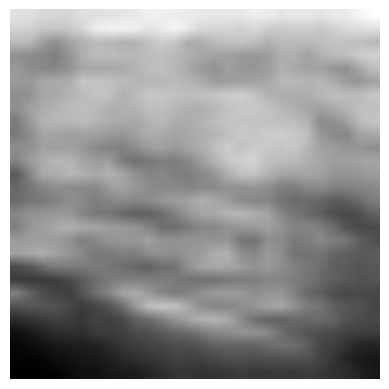

In [88]:
import torch
from PIL import Image
from torchvision import transforms

# Assume 'model' is your trained model
network.eval()

# Assuming you have a DataLoader for your test data
# For a specific image, you might load it directly as shown below
image, label = pil_dataset[110]

# Transform the image according to your model's expected input
# This should match your training transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example size, adjust as necessary
    transforms.ToTensor(),
    # Include normalization if used during training
])

# Apply transformation
image = transform(image).unsqueeze(0)  # Add batch dimension

# Move image to the same device as your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)
model = network.to(device)

with torch.no_grad():
    output = model(image)

# Assuming the output is logits; apply softmax for probabilities
probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Assuming class 0 is 'benign' and class 1 is 'malignant'
classes = ['benign', 'malignant']
predicted_class = classes[probabilities.argmax()]
confidence = probabilities.max()

print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")


image_np = image.squeeze().cpu().numpy()

# If the image is grayscale (C, H, W) where C = 1, we convert it to (H, W) for matplotlib
if image_np.shape[0] == 1:  # Grayscale image, single channel
    image_np = image_np.squeeze(0)  # Now shape is (H, W)
elif image_np.shape[0] == 3:  # If it's a 3-channel image
    # Convert from (C, H, W) to (H, W, C) for RGB images
    image_np = np.transpose(image_np, (1, 2, 0))

# Display the image
plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
plt.axis('off')
plt.show()